In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
#import sys
#!{sys.executable} -m pip install sagemaker -U
#!{sys.executable} -m pip install sagemaker-experiments

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import boto3
import re
from datetime import datetime

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.s3 import S3Uploader, S3Downloader

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker
from sklearn.model_selection import train_test_split

%cd /root/predicting-coronavirus
%pip install mpu
import src.data_import as di
#import src.data_tools as dt
import src.airport_index as ap

%matplotlib inline
pd.set_option('display.max_columns', 500)  
pd.set_option('display.max_rows', 500)   

/root/predicting-coronavirus
Note: you may need to restart the kernel to use updated packages.


In [34]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()

In [7]:
!cd data/covid-19-data;git pull origin master

remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15 (delta 9), reused 14 (delta 9), pack-reused 1
Unpacking objects: 100% (15/15), done.
From https://github.com/nytimes/covid-19-data
 * branch            master     -> FETCH_HEAD
   b761184..c95c96f  master     -> origin/master
Updating b761184..c95c96f
Fast-forward
 README.md            |   53 +-
 live/us-counties.csv | 2998 ++++++++++++++++++++++++++
 live/us-states.csv   |   56 +
 live/us.csv          |    2 +
 us-counties.csv      | 5841 +++++++++++++++++++++++++++++++++++++++++++++++++-
 us-states.csv        |  114 +-
 us.csv               |    4 +-
 7 files changed, 9054 insertions(+), 14 deletions(-)
 create mode 100644 live/us-counties.csv
 create mode 100644 live/us-states.csv
 create mode 100644 live/us.csv


In [6]:
account_id = sess.client('sts', region_name=sess.region_name).get_caller_identity()["Account"]
bucket = 'sagemaker-studio-{}-{}'.format(sess.region_name, account_id)
prefix = 'capstone2'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print("Looks like you already have a bucket of this name. That's good. Uploading the data files...")

# Return the URLs of the uploaded file, so they can be reviewed or used elsewhere
s3url = S3Uploader.upload('data/covid-19-data/us-counties.csv', 's3://{}/{}/{}'.format(bucket, prefix,'nyt'))
print(s3url)


s3://sagemaker-studio-us-east-1-752222400982/capstone2/nyt/us-counties.csv


In [7]:
#etl = dt.etl()
#nyt = etl.load_nyt()
nyt = di.extract_nyt()

In [8]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139802 entries, 0 to 141402
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    139802 non-null  datetime64[ns]
 1   county  139802 non-null  object        
 2   state   139802 non-null  object        
 3   fips    139802 non-null  int64         
 4   cases   139802 non-null  int64         
 5   deaths  139802 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 7.5+ MB


In [9]:
#Get the maximum cases and deaths for each fips
max_cases = nyt.groupby('fips').max()
max_cases = max_cases[['cases', 'deaths']]
#max_cases['deaths'].sum()
#max_cases

In [10]:
hhi = di.extract_hhi()
edu = di.extract_edu()
pubtrans = di.extract_public_transport()
housing = di.extract_housing()
election = di.extract_election()
geo = di.extract_geography()
counties = ap.extract_geography()
airports = ap.extract_airports()
intl_index = ap.build_intl_arrivals_index_df2(counties, airports, 30, 200)
sip = di.extract_sip()


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/root/predicting-coronavirus/src/data_import.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['hs'] = ret['hs']/100
/root/predicting-coronavirus/src/data_import.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['ba_plus'] = ret['ba_plus']/100
/root/predicting-coronavirus/src/data_import.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

<class 'pandas.core.series.Series'>


In [46]:
nyt = di.extract_nyt()

In [58]:
per100k = pd.merge(nyt, geo, how='inner', left_on=['fips'], right_on=['fips'])
per100k = per100k[['fips', 'state', 'population', 'date', 'cases', 'deaths']]
per100k['death_rate'] = per100k.apply(lambda row: (row['deaths']/row['population'])*100000, axis=1)
per100k['case_rate'] = per100k.apply(lambda row: (row['cases']/row['population'])*100000, axis=1)
per100k


,fips,state,population,date,cases,deaths,death_rate,case_rate
0,53061,Washington,713335,2020-01-21,1,0,0.0,0.140187
1,53061,Washington,713335,2020-01-22,1,0,0.0,0.140187
2,53061,Washington,713335,2020-01-23,1,0,0.0,0.140187
3,53061,Washington,713335,2020-01-24,1,0,0.0,0.140187
4,53061,Washington,713335,2020-01-25,1,0,0.0,0.140187
...,...,...,...,...,...,...,...,...
139797,31071,Nebraska,2049,2020-05-12,1,0,0.0,48.804295
139798,31071,Nebraska,2049,2020-05-13,1,0,0.0,48.804295
139799,17047,Illinois,6721,2020-05-13,2,0,0.0,29.757477
139800,19063,Iowa,10302,2020-05-13,1,0,0.0,9.706853


In [59]:
ten = per100k[per100k['case_rate'] > 10].groupby('fips').min()
ten = ten[['date']]
ten.columns = ['date_10']
#ten['date_10'].fillna(datetime(2020,5,15))

In [60]:
# Temportal stuff
ts_df = pd.merge(per100k, ten, how='left', left_on=['fips'], right_on=['fips'])
ts_df = pd.merge(ts_df, sip, how='left', left_on=['state'], right_on=['state'])


In [63]:
def days_since(row, calc_date):
    row['days_since_sip'] = int((calc_date - row['sip']).days)
    lifted = int((calc_date - row['sip_lifted']).days)
    if(lifted < 0):
        lifted = 0
    row['days_since_sip_lifted'] = lifted
    ten_per = row['date_10']
    if pd.isnull(ten_per):
        row['days_since_10p100k'] = 0
    else:
        row['days_since_10p100k'] = int((calc_date - ten_per).days)
    return row
ts_df['case_rate'] = ts_df['case_rate'].fillna(0)
ts_df['death_rate'] = ts_df['death_rate'].fillna(0)
ts_df = ts_df.apply(days_since, axis=1, args=[(datetime(2020,5,15))])


In [65]:
ts_df.to_csv('./data/ts_df.csv', header=False)


In [64]:
ts_df

,fips,state,population,date,cases,deaths,death_rate,case_rate,date_10,sip,sip_lifted,days_since_sip,days_since_sip_lifted,days_since_10p100k
0,53061,Washington,713335,2020-01-21,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
1,53061,Washington,713335,2020-01-22,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
2,53061,Washington,713335,2020-01-23,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
3,53061,Washington,713335,2020-01-24,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
4,53061,Washington,713335,2020-01-25,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139797,31071,Nebraska,2049,2020-05-12,1,0,0.0,48.804295,2020-05-12,2020-05-15,2020-05-15,0,0,3
139798,31071,Nebraska,2049,2020-05-13,1,0,0.0,48.804295,2020-05-12,2020-05-15,2020-05-15,0,0,3
139799,17047,Illinois,6721,2020-05-13,2,0,0.0,29.757477,2020-05-13,2020-03-20,2020-05-29,56,0,2
139800,19063,Iowa,10302,2020-05-13,1,0,0.0,9.706853,NaT,2020-05-15,2020-05-15,0,0,0


In [89]:
# Geography and demographics
big_df = pd.merge(geo, election, how='left', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, intl_index[['fips', 'international']], how='left', left_on=['fips'], right_on=['fips'])


In [90]:
big_df

,sc,fips,state,county,population,area-km,per_dem,per_gop,international
0,Alabama:Autauga,1001,Alabama,Autauga,54571,1539.582,0.239569,0.734358,1.000000
1,Alabama:Baldwin,1003,Alabama,Baldwin,182265,4117.522,0.195653,0.773515,1.000000
2,Alabama:Barbour,1005,Alabama,Barbour,27457,2291.819,0.466603,0.522714,1.000000
3,Alabama:Bibb,1007,Alabama,Bibb,22915,1612.481,0.214220,0.769662,1.000000
4,Alabama:Blount,1009,Alabama,Blount,57322,1669.962,0.084699,0.898519,1.000000
...,...,...,...,...,...,...,...,...,...
3138,Wyoming:Sweetwater,56037,Wyoming,Sweetwater,43806,27004.897,0.194046,0.729428,1.000000
3139,Wyoming:Teton,56039,Wyoming,Teton,21294,10347.984,0.600608,0.321945,1.000000
3140,Wyoming:Uinta,56041,Wyoming,Uinta,21118,5390.450,0.149261,0.764187,179025.335253
3141,Wyoming:Washakie,56043,Wyoming,Washakie,8533,5797.815,0.143203,0.783580,1.000000


In [94]:
big_df['pop_density'] = big_df['population']/big_df['area-km']

demo_df = big_df.drop([ 'population', 'area-km'], axis=1)



In [95]:
final_df = pd.merge(ts_df, demo_df, how='left', left_on=['fips'], right_on=['fips'])

In [97]:
final_df = final_df[['fips',
                     #'date',
                     'death_rate',
                     'case_rate',
                     'days_since_sip',
                     'days_since_sip_lifted',
                     'days_since_10p100k',
                     #'median_hhi',
                     #'hs',
                     #'ba_plus',
                     #'ma_plus',
                     #'median_house_price',
                     #'median_rent',
                     #'percent_big_buildings',
                     #'percent_commuter',
                     'international',
                     #'percent_over_65',
                     'pop_density',
                     #'hh_density'
                    ]]

In [101]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139802 entries, 0 to 139801
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fips                   139802 non-null  object 
 1   death_rate             139802 non-null  float64
 2   case_rate              139802 non-null  float64
 3   days_since_sip         139802 non-null  int64  
 4   days_since_sip_lifted  139802 non-null  int64  
 5   days_since_10p100k     139802 non-null  int64  
 6   international          139802 non-null  float64
 7   pop_density            139802 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 9.6+ MB


In [99]:
save_df = final_df.drop(['death_rate', 'fips'], axis=1).set_index('case_rate')
save_trainval, save_test = train_test_split(save_df) 
save_train, save_val = train_test_split(save_trainval) 

save_train.to_csv('./data/train3k.csv', header=False)
save_val.to_csv('./data/val3k.csv', header=False)
save_test.to_csv('./data/test3k.csv', header=False)
save_df.to_csv('./data/merged3k.csv')

In [104]:
y = final_df['case_rate']
X = final_df.drop(['case_rate', 'death_rate'], axis=1).set_index('fips')


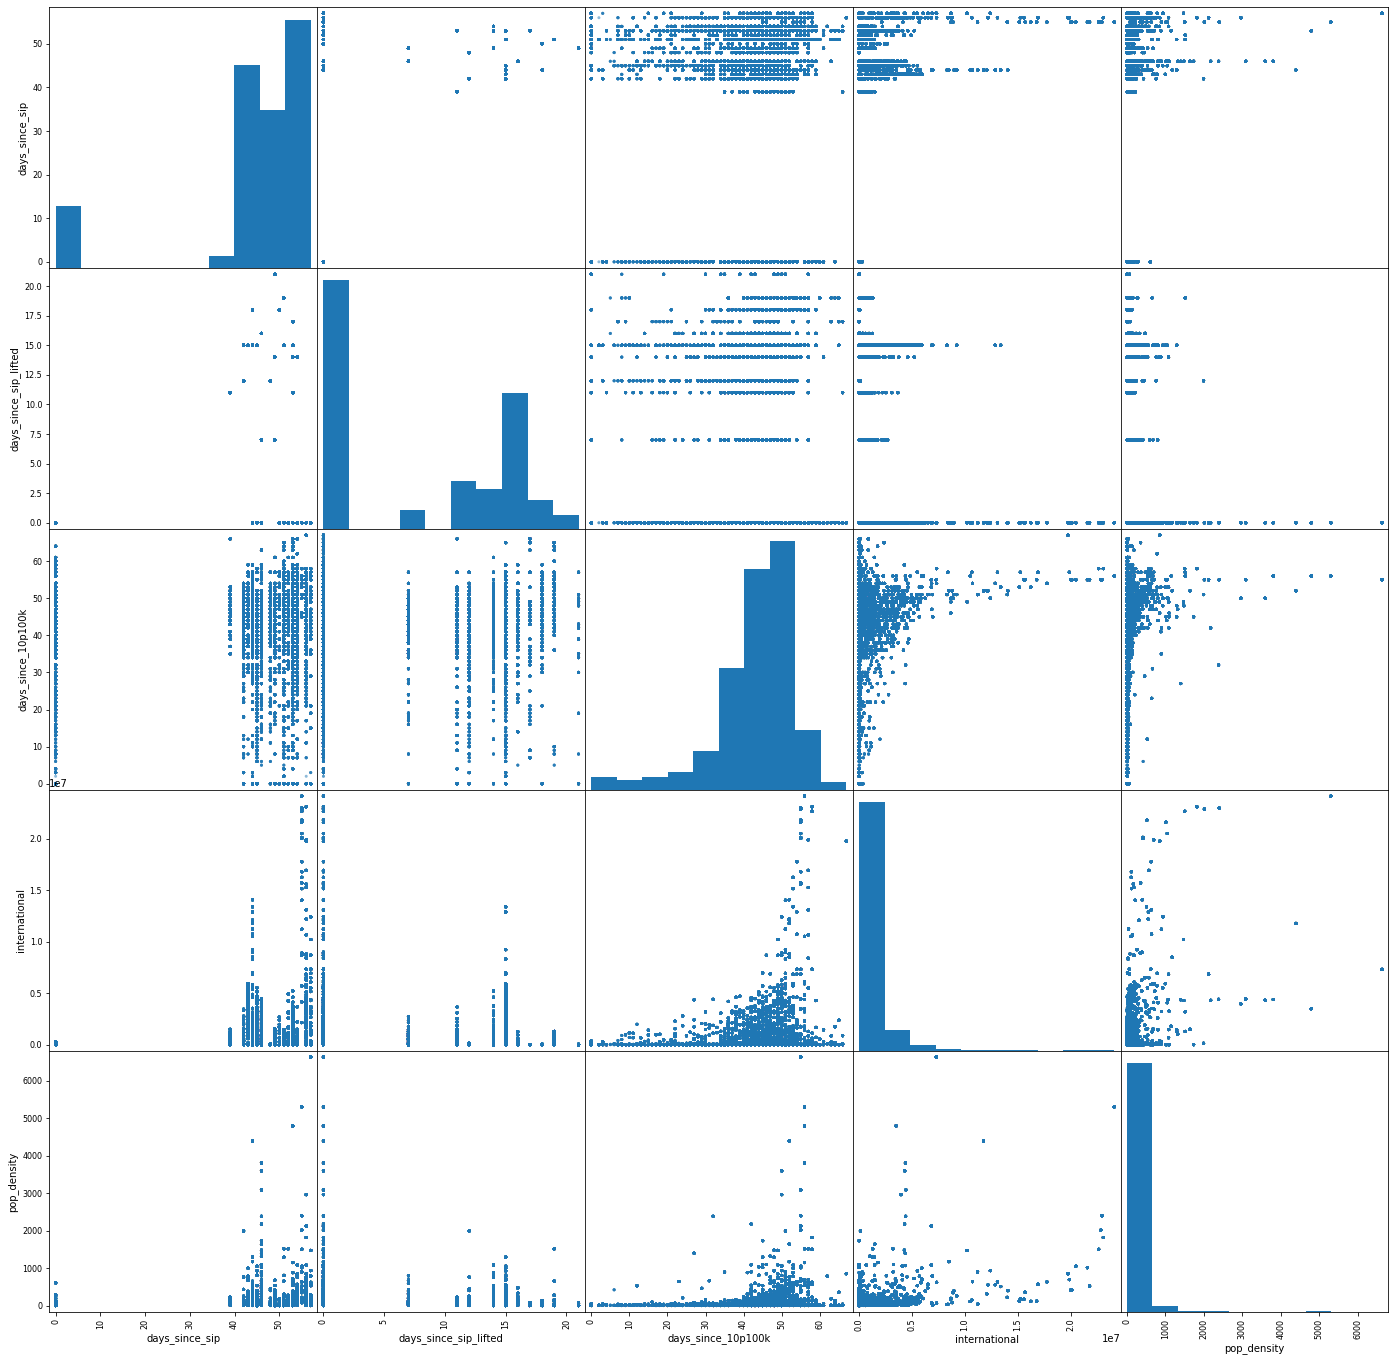

In [105]:
xxx = pd.plotting.scatter_matrix(X, figsize=(24,24))

In [106]:
X.describe()

,days_since_sip,days_since_sip_lifted,days_since_10p100k,international,pop_density
count,139802.000000,139802.000000,139802.000000,1.398020e+05,139802.000000
mean,44.496395,7.653918,43.097066,9.088445e+05,109.533839
std,14.795031,7.422488,10.658370,2.474759e+06,367.676339
min,0.000000,0.000000,0.000000,1.000000e+00,0.014828
25%,44.000000,0.000000,40.000000,1.000000e+00,10.289144
50%,48.000000,7.000000,45.000000,2.671042e+04,23.648309
75%,53.000000,15.000000,50.000000,6.246062e+05,66.067442
max,57.000000,21.000000,67.000000,2.412791e+07,6632.907743


Mean cross-validation score: 0.08


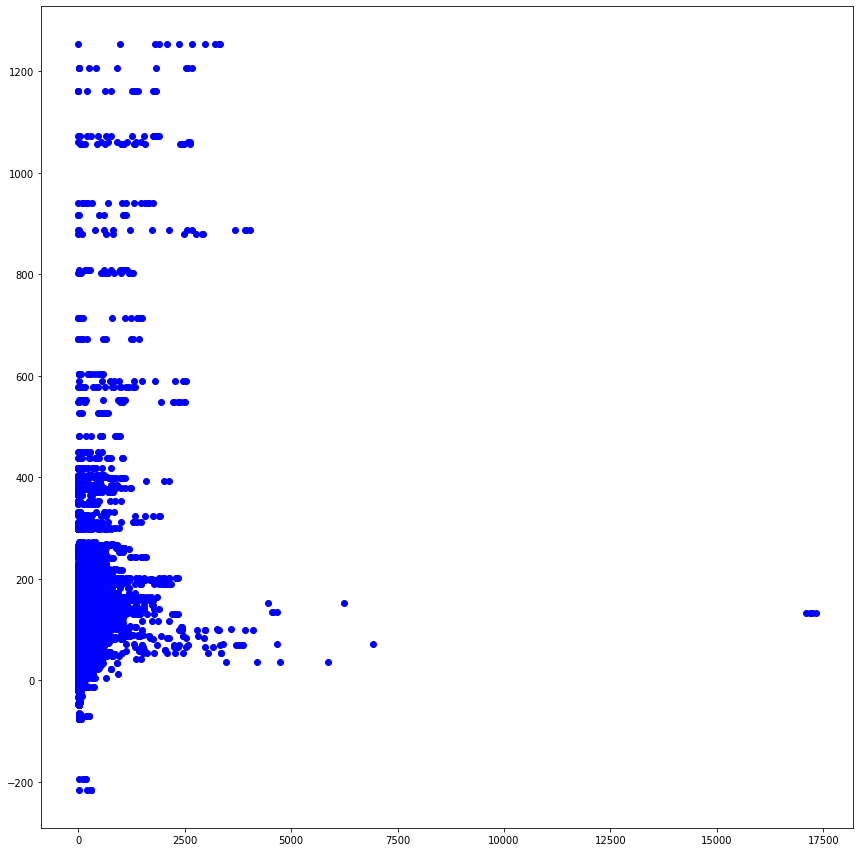

In [107]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
poly.fit(X_train_poly, y_train)
lin = LinearRegression()
lin.fit(X_train_poly, y_train)
X_test_poly = poly.fit_transform(X_test)
predicted = lin.predict(X_test_poly)

fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
plt.scatter(y_test, predicted, color = 'blue', label="actual data") 
#lin.score(X_train_poly, y_train)
#lin.score(X_test_poly, y_test)
scores = cross_val_score(lin, X_train,y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

In [108]:
rms = sqrt(mean_squared_error(y_test, predicted))
rms

319.6521860072686

In [109]:
#%pip install xgboost
import xgboost as xgb

In [110]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)


In [111]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Mean cross-validation score: 0.39


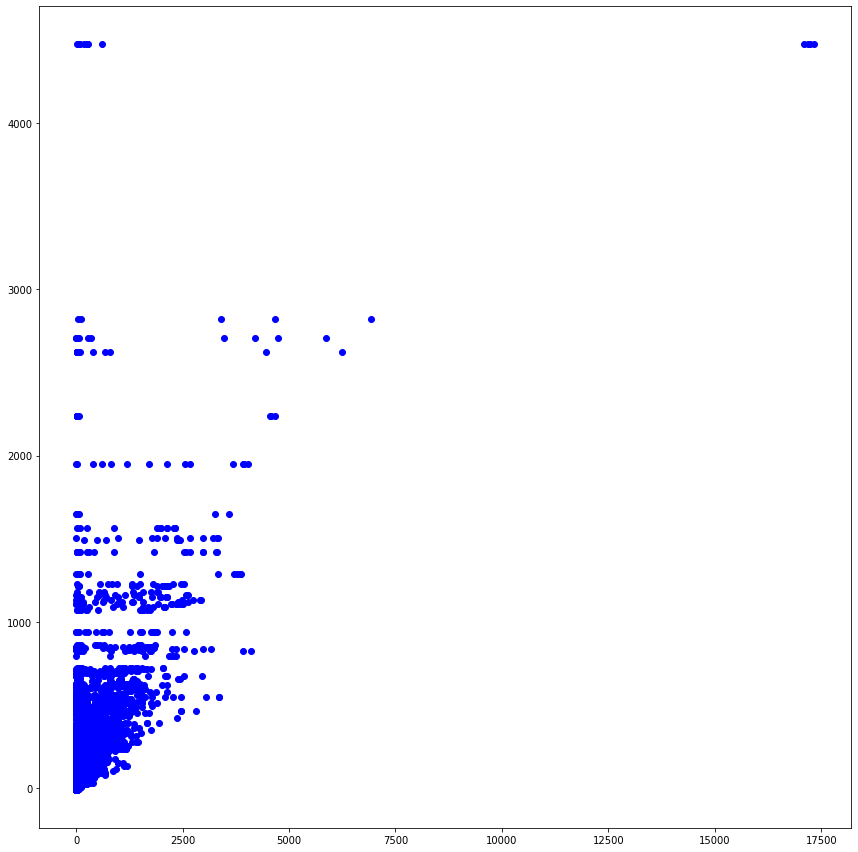

In [112]:
predicted = xgbr.predict(X_test)
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
plt.scatter(y_test, predicted, color = 'blue', label="actual data") 
#lin.score(X_train_poly, y_train)
#lin.score(X_test_poly, y_test)
scores = cross_val_score(xgbr, X_train, y_train, cv=5)

print("Mean cross-validation score: %.2f" % scores.mean())

In [113]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, predicted))
rms

260.3495636242682

In [114]:
dumb = np.full(len(y_test), np.mean(y_test))
sqrt(mean_squared_error(y_test, dumb))

334.1763126444482

In [293]:
y.describe()

count     827.000000
mean      297.587130
std       427.774475
min         0.000000
25%        82.204788
50%       163.425530
75%       320.521947
max      4005.300189
Name: case_rate, dtype: float64